In [1]:
import numpy as np
import sys,math
sys.path.append('../../../programs/extractdropletdata/')
import millidrop_dataclass as mdc
import os,glob
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12,8]
matplotlib.rc('font',family='Monospace')

In [27]:
dropfiles = glob.glob('droplets/*.csv')
templatefile = 'template.csv'

# fluo_1_mean: PVD
# fluo_2_mean: mCherry
# fluo_3_mean: GFP
# fluo_4_mean: YFP

kwargs = {'infiles':dropfiles,
          'templatefile':templatefile,
          'datacolumns':['time','fluo_3_mean','fluo_1_mean','fluo_2_mean'],
          'IgnoreAdditionalDroplets':True,
          'SplitBackForthTrajectories':True}

data = mdc.DropletData(**kwargs)
data.set_restriction('max','all',['time',40*3.6e3])
data.set_restriction('exclude','Empty',['experiment'])


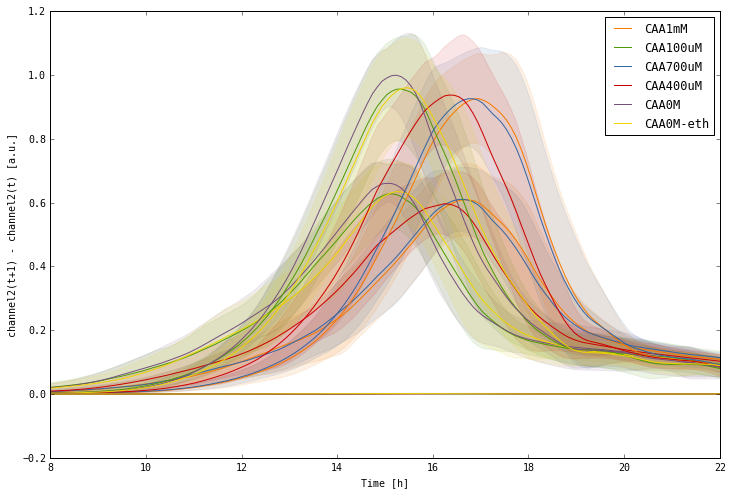

In [36]:
col = ['#f57900','#4e9a06','#3465a4','#cc0000','#75507b','#edd400']
i = 0
count = 400
excludelabels = ['Empty']
lgnd = []
newtime = np.linspace(start = 0,stop = 40, num = count)
for label,trajectories in data:
    if not label in excludelabels:
        st  = np.zeros(count)
        stt = np.zeros(count)
        n = 0
        for t in trajectories:
            tmp_interp = np.interp(newtime,t[:-1,0]/3.6e3,np.diff(t[:,1]))
            st += tmp_interp
            stt += tmp_interp * tmp_interp
            n += 1
            #steepest.append(t[np.max(np.diff(t[:,1])),0]/3.6e3)
            #plt.plot(t[:-1,0]/3.6e3,np.diff(t[:,1]),c=col[i],alpha = .1)
        #plt.ylim([0,.02])
        m = st/n
        v = np.sqrt(n*stt - st*st)/np.sqrt(n*n-n)
        plt.plot(newtime,m,c = col[i])
        plt.fill_between(newtime,m-v,m+v,color = col[i],alpha=.1)
        lgnd.append(label)
        #plt.hist(steepest,bins=40,range=(0,40),color = col[i],alpha=.2)

        i+=1
plt.legend(lgnd)
plt.xlim((8,22))
plt.xlabel('Time [h]')
plt.ylabel('GFP(t+1) - GFP(t) [a.u.] (channel3)')
#plt.show()
plt.savefig('channel3_zoom.png')


CAA1mM 1.67167167167 0.263078258766
CAA100uM 0.26026026026 0.643576177343
CAA700uM 1.58658658659 0.486994526972
CAA400uM 1.15615615616 0.254211579171
CAA0M 0.0 0.0
CAA0M-eth 0.32032032032 0.298244874182


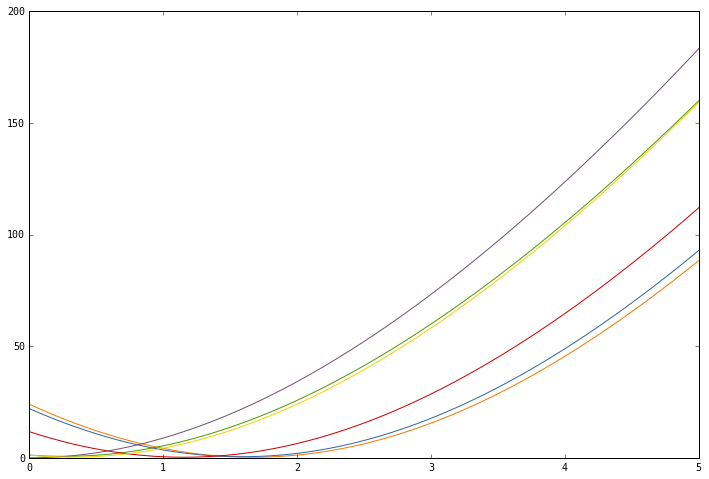

In [51]:
col = ['#f57900','#4e9a06','#3465a4','#cc0000','#75507b','#edd400']
i = 0
count = 400
excludelabels = ['Empty']
lgnd = []
newtime = np.linspace(start = 0,stop = 40, num = count)

m = dict()
v = dict()

for label,trajectories in data:
    if not label in excludelabels:
        st  = np.zeros(count)
        stt = np.zeros(count)
        n = 0
        for t in trajectories:
            tmp_interp = np.interp(newtime,t[:,0]/3.6e3,t[:,1])
            st  += tmp_interp
            stt += tmp_interp * tmp_interp
            n   += 1
        m[label] = st/n
        v[label] = np.sqrt(n*stt - st*st)/np.sqrt(n*n-n)
        #plt.plot(newtime,np.log(m[label]),c = col[i])
        #plt.fill_between(newtime,np.log(m[label]-v[label]),np.log(m[label]+v[label]),color = col[i],alpha=.1)
        #lgnd.append(label)
        i+=1
#plt.legend(lgnd)
#plt.xlim((0,40))
#plt.xlabel('Time [h]')
#plt.ylabel('GFP [a.u.]')
#plt.show()
#plt.savefig('channel3.svg',format='svg')


countshifts = 1000
shift = np.linspace(start = 0,stop = 5, num = countshifts)
deviation = dict()
j = 0
for label in [x for x in data.listoftypes if not x in excludelabels]:
    deviation[label] = np.zeros(countshifts)
    for i in range(len(shift)):
        tmpsignal = np.interp(newtime + shift[i],newtime,m[label])
        deviation[label][i] = np.sum((m['CAA0M']-tmpsignal)*(m['CAA0M']-tmpsignal))
    plt.plot(shift,deviation[label],c=col[j])
    mindevarg = deviation[label].argmin()
    print label,shift[mindevarg],deviation[label][mindevarg]
    j += 1
plt.show()




In [52]:
def MLSQ_fit(x,y):
    a = (len(x) * np.sum(x * y) - np.sum(x)*np.sum(y))/(len(x) * np.sum(x*x) - np.sum(x)*np.sum(x))
    b = (np.sum(y) - a * np.sum(x))/np.sum(x)
    return a,b

def compute_R2(val,pred):
    return 1 - np.sum((val-pred)**2)/np.sum((val - np.mean(val))**2)

def linfit(x,coeff):
    return coeff[0]*x + coeff[1]

CAA1mM 0.972 0.251 0.938
CAA100uM 0.984 0.317 0.933
CAA700uM 0.954 0.253 0.883
CAA400uM 0.993 0.297 0.919
CAA0M 0.931 0.233 0.878
CAA0M-eth 0.989 0.263 0.944


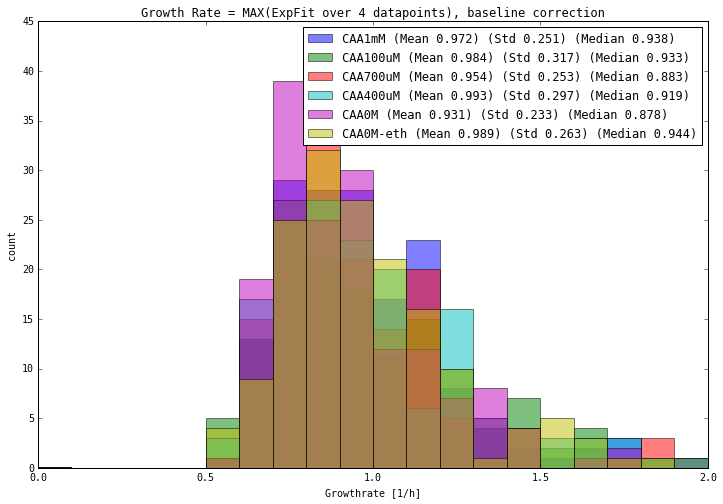

In [58]:
number_points = 4
lgnd = list()
for label,trajectories in data:
    if not label in excludelabels: #label.upper() != 'SEPARATOR':
        gr = list()
        y = list()
        for t in trajectories:
            t[:,0] /= 3.6e3
            t[:,1] = np.abs(t[:,1]  + 1.49028579754e-07*3.6e3*t[:,0] - 0.0873583211834)
            
            grt = np.array([(number_points * np.sum(t[i:i+number_points,0] * np.log(t[i:i+number_points,1])) - np.sum(t[i:i+number_points,0])*np.sum(np.log(t[i:i+number_points,1]))) / \
                            (number_points * np.sum(t[i:i+number_points,0] * t[i:i+number_points,0])         - np.sum(t[i:i+number_points,0])*np.sum(t[i:i+number_points,0])) for i in range(len(t[:,0]-number_points))])
            
            
            gr.append(np.max(grt))
            y.append(np.max(t[:,1]))
            
        plt.hist(gr,range=(0,2),bins=20,alpha=.5)
        plt.xlabel('Growthrate [1/h]')
        plt.ylabel('count')
        lgnd.append('{:3s} (Mean {:.3f}) (Std {:.3f}) (Median {:.3f})'.format(label,np.mean(gr),np.std(gr),np.median(gr)))
        print '{} {:.3f} {:.3f} {:.3f}'.format(label,np.mean(gr),np.std(gr),np.median(gr))
plt.title('Growth Rate = MAX(ExpFit over 4 datapoints), baseline correction')

plt.legend(lgnd)
plt.show()